# Прогнозирование температуры звезды

## Введение

Задача от обсерватории «Небо на ладони»: придумать, как с помощью нейросети определять температуру на поверхности обнаруженных звёзд. Обычно для расчёта температуры учёные пользуются следующими методами:
- Закон смещения Вина.
- Закон Стефана-Больцмана.
- Спектральный анализ.

Каждый из них имеет плюсы и минусы. Обсерватория хочет внедрить технологии машинного обучения для предсказания температуры звёзд, надеясь, что этот метод будет наиболее точным и удобным.

В базе обсерватории есть характеристики уже изученных 240 звёзд.

**Необходимо разработать нейронную сеть, которая поможет предсказывать абсолютную температуру на поверхности звезды.**

## Описание данных

- Относительная светимость **L/Lo** — светимость звезды относительно Солнца.
- Относительный радиус **R/Ro** — радиус звезды относительно радиуса Солнца.
- Абсолютная звёздная величина **Mv** — физическая величина, характеризующая блеск звезды.
- Звёздный **цвет** (white, red, blue, yellow, yellow-orange и др.) — цвет звезды, который определяют на основе спектрального анализа.
- **Тип звезды**.
|Тип звезды|Номер, соответствующий типу|
|:--|:--:|
|Коричневый карлик|0|
|Красный карлик|1|
|Белый карлик|2|
|Звёзды главной последовательности|3|
|Сверхгигант|4|
|Гипергигант|5|
- Абсолютная температура **T(K)** — температура на поверхности звезды в Кельвинах.


## Импорт библиотек

In [1]:
import pandas as pd
import torch 
import torch.nn as nn
import random
import numpy as np
import matplotlib.pyplot as plt
from math import ceil

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder

## Загрузка данных

In [2]:
def first_look(df, num_of_srtings=5):
    '''
    функция для первичного знакомства с данными
    '''
    print('Общая информация')
    display(df.info())
    
    print(f'Первые {num_of_srtings} строк(и) данных')
    display(df.head(num_of_srtings))
    
    print('Основные статистические характеристики данных')
    display(df.describe())
    print('Количество пропусков:')
    print(df.isna().sum())
    print()
    
    print('Количество дубликатов:', df.duplicated().sum())

In [3]:
data = pd.read_csv('/datasets/6_class.csv', index_col=0)

In [4]:
first_look(data)

Общая информация
<class 'pandas.core.frame.DataFrame'>
Int64Index: 240 entries, 0 to 239
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Temperature (K)         240 non-null    int64  
 1   Luminosity(L/Lo)        240 non-null    float64
 2   Radius(R/Ro)            240 non-null    float64
 3   Absolute magnitude(Mv)  240 non-null    float64
 4   Star type               240 non-null    int64  
 5   Star color              240 non-null    object 
dtypes: float64(3), int64(2), object(1)
memory usage: 13.1+ KB


None

Первые 5 строк(и) данных


,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
0,3068,0.002400,0.1700,16.12,0,Red
1,3042,0.000500,0.1542,16.60,0,Red
2,2600,0.000300,0.1020,18.70,0,Red
3,2800,0.000200,0.1600,16.65,0,Red
4,1939,0.000138,0.1030,20.06,0,Red


Основные статистические характеристики данных


,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type
count,240.000000,240.000000,240.000000,240.000000,240.000000
mean,10497.462500,107188.361635,237.157781,4.382396,2.500000
std,9552.425037,179432.244940,517.155763,10.532512,1.711394
min,1939.000000,0.000080,0.008400,-11.920000,0.000000
25%,3344.250000,0.000865,0.102750,-6.232500,1.000000
50%,5776.000000,0.070500,0.762500,8.313000,2.500000
75%,15055.500000,198050.000000,42.750000,13.697500,4.000000
max,40000.000000,849420.000000,1948.500000,20.060000,5.000000


Количество пропусков:
Temperature (K)           0
Luminosity(L/Lo)          0
Radius(R/Ro)              0
Absolute magnitude(Mv)    0
Star type                 0
Star color                0
dtype: int64

Количество дубликатов: 0


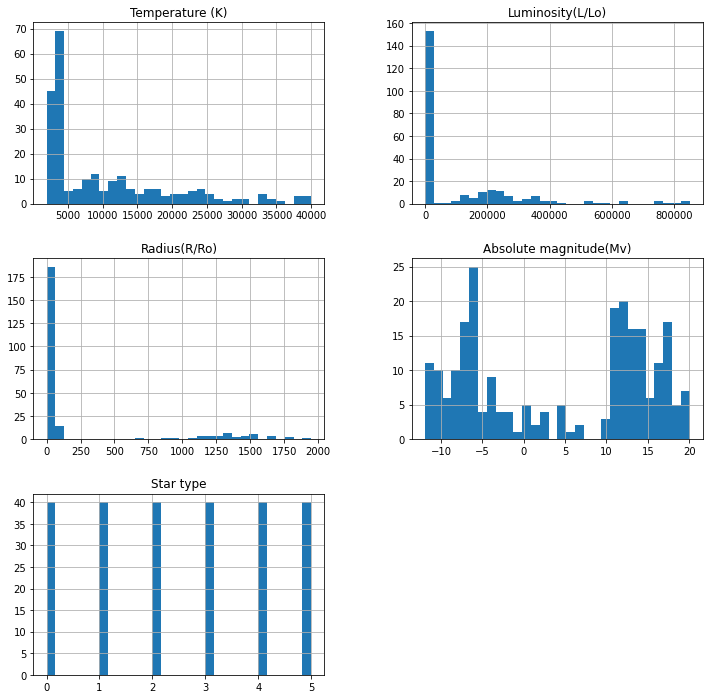

In [5]:
data.hist(
    bins=30,
    figsize=(12, 12)
);

In [6]:
# процент данных о звездах с температурой ниже 5 000 К
data[data['Temperature (K)'] < 5_000].shape[0] / data.shape[0] * 100

48.333333333333336

В доступном наборе данных содержатся результаты измерений шести параметров 240 звезд. Явных дубликатов и пропусков нет.

Три признака количественные, два – категориальные, причем один из них (тип звезды) представлен числом. 

Большинство звезд имеют температуру ниже 5000 К, относительный радиус и относительную светимость, близкие к показателям Солнца. Абсолютная звёздная величина принимает как отрицательные, так и положительные значения. 

Температура звезд в предоставленном наборе данных меняется в диапазоне от 1 939 К до 40 000 К. На гистограмме видно, что 48 % наблюдений имеет температуру до 5 000 К. Для звезд с большей температурой примеров относительно меньше.

Отрицательную звездную величину имеют самые яркие звезды, а также некоторые планеты и галактики. Например, самая яркая звезда на нашем небосводе — Сириус, имеет отрицательную звездную величину -1,46. 
Также, планета Венера может иметь отрицательную звездную величину при своем максимальном сиянии. Практический пример использования отрицательной звездной величины — это использование астрономами для поиска наиболее ярких объектов на небе.

На гистограммах видно, что числовые характеристики принимают значения в различных диапазонах, следовательно, данные нужно будет масштабировать.

Всего в наборе есть данные о 6 типах звезд, по 40 примеров каждого типа.

## Предобработка и анализ данных

В названиях столбцов присутствуют пробелы и заглавные буквы. Изменим регистр на нижний во всех случаях, а пробелы заменим нижним подчеркиванием.

In [7]:
# изменяем регистр
data.columns = data.columns.str.lower()

In [8]:
# заменяем пробелы нижним подчеркиванием
data.columns = data.columns.str.replace('(', ' (', regex=True)
data.columns = data.columns.str.replace('  ', ' ')
data.columns = data.columns.str.replace(' ', '_')

In [9]:
# проверяем результат
data.columns

Index(['temperature_(k)', 'luminosity_(l/lo)', 'radius_(r/ro)',
       'absolute_magnitude_(mv)', 'star_type', 'star_color'],
      dtype='object')

### Цвет звезды

Посмотрим количество уникальных значений.

In [10]:
data['star_color'].nunique()

19

In [11]:
data['star_color'].value_counts()

Red                   112
Blue                   55
Blue-white             26
Blue White             10
yellow-white            8
White                   7
Blue white              3
white                   3
Yellowish White         3
Whitish                 2
Orange                  2
yellowish               2
Pale yellow orange      1
White-Yellow            1
Blue                    1
Blue white              1
Yellowish               1
Blue-White              1
Orange-Red              1
Name: star_color, dtype: int64

Категориальный признак «Цвет звезды» содержит 19 значений, среди них присутствуют неявные дубликаты. Встречаются разные способы обозначения цвета, непостоянство в регистрах, лишние пробелы. Изменим их по следующему правилу: названия цветов начинаются с маленькой буквы, несколько цветов пишутся через пробел, без окончания -ish.

In [12]:
# изменим регистр
data['star_color'] = data['star_color'].str.lower()

Обработаем дубликаты.

In [13]:
# словарь для замены неявных дубликатов цвета звезды
star_color_to_replace = {
    "blue-white" : "blue white",
    "blue white " : "blue white",
    "yellow-white" : "yellow white",
    "yellowish white" : "yellow white",
    "white-yellow" : "yellow white",
    "whitish" : "white",
    "blue " : "blue",
    "orange-red" : "orange red",
    "pale yellow orange " : "yellow orange",
    "yellowish " : "yellow",
}

# проводим замену
data['star_color'].replace(star_color_to_replace, inplace=True)


Посмотрим на результат преобразований.

In [14]:
# количество уникальных значений
data['star_color'].nunique()

9

In [15]:
data['star_color'].value_counts()

red                   112
blue                   56
blue white             41
white                  12
yellow white           12
yellowish               3
orange                  2
orange red              1
pale yellow orange      1
Name: star_color, dtype: int64

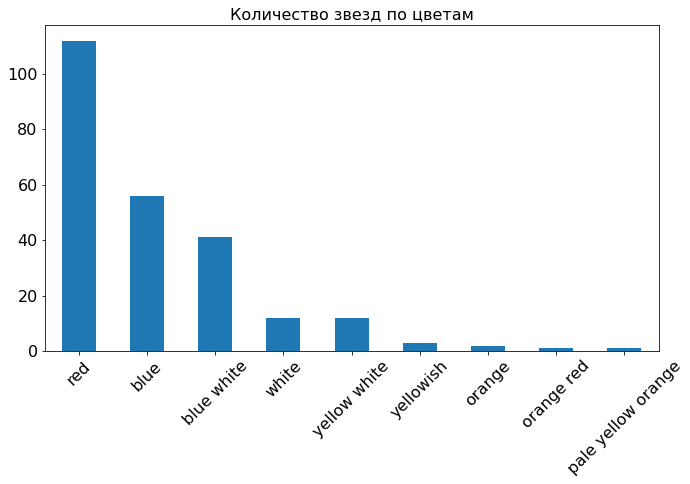

In [16]:
chart = data['star_color'].value_counts().plot(
        kind='bar',
        rot=45,
        figsize=(11, 6),
        fontsize=16
    )
chart.set_title('Количество звезд по цветам', fontsize=16);

По диаграмме видно, что из девяти цветов чаще всего в наборе данных встречается красный, на втором месте по популярности голубой и бело-голубой.

### Подготовка данных к обучению модели

#### Выделение выборок

Разобьем наши данные на тестовую и тренировочную выборки.

In [17]:
x_train, x_test, y_train, y_test = train_test_split(
    data.drop('temperature_(k)', axis=1),
    data['temperature_(k)'],
    test_size=.3,
    shuffle=True,
    random_state=42
)

In [18]:
# проверка правильности разбиения
x_train.shape[0] + x_test.shape[0] == data.shape[0]

True

In [19]:
# проверка правильности разбиения
y_train.shape[0] + y_test.shape[0] == data.shape[0]

True

In [20]:
x_train.head()

,luminosity_(l/lo),radius_(r/ro),absolute_magnitude_(mv),star_type,star_color
29,0.00008,0.0130,14.08,2,pale yellow orange
124,0.00064,0.1090,17.12,0,red
75,0.00100,0.3500,11.76,1,red
82,0.00056,0.0095,13.78,2,white
5,0.00065,0.1100,16.98,0,red


#### Обработка категориальных значений

После разбиения данных на выборки проведем обработку категориальных значений, а затем масштабируем данные.

К категориальным признакам относятся цвет звезды и ее тип.

In [21]:
numeric = ['luminosity_(l/lo)', 'radius_(r/ro)', 'absolute_magnitude_(mv)']
categorical = ['star_color', 'star_type']

Для преобразования категориальных значений будем использовать технику One-Hot кодирования. Воспользуемся инструментом из библиотеки Scikit Learn.

In [22]:
# инициализация кодировщика 
ohe = OneHotEncoder(
    sparse=False,
    handle_unknown='ignore'
)

In [23]:
# обучение кодировщика
# и обработка тренировочной выборки

x_train_cat = x_train[categorical]
x_train_cat =  pd.DataFrame(ohe.fit_transform(x_train_cat))

In [24]:
x_train_cat.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [25]:
# обработка тестовой выборки
x_test_cat = x_test[categorical]
x_test_cat = pd.DataFrame(ohe.transform(x_test_cat))

In [26]:
x_test_cat.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


Собираем вместе числовые и обработанные категориальные признаки.

In [27]:
# тренировочная выборка
x_train_ohe =pd.merge(
    x_train[numeric].reset_index(drop=True),
    x_train_cat.add_prefix('ohe'),
    left_index=True, 
    right_index=True)

In [28]:
x_train_ohe.head()

,luminosity_(l/lo),radius_(r/ro),absolute_magnitude_(mv),ohe0,ohe1,ohe2,ohe3,ohe4,ohe5,ohe6,ohe7,ohe8,ohe9,ohe10,ohe11,ohe12,ohe13
0,0.00008,0.0130,14.08,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.00064,0.1090,17.12,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.00100,0.3500,11.76,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.00056,0.0095,13.78,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.00065,0.1100,16.98,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [29]:
# тестовая выборка
x_test_ohe =pd.merge(
    x_test[numeric].reset_index(drop=True),
    x_test_cat.add_prefix('ohe'),
    left_index=True, 
    right_index=True)

In [30]:
x_test_ohe.head()

,luminosity_(l/lo),radius_(r/ro),absolute_magnitude_(mv),ohe0,ohe1,ohe2,ohe3,ohe4,ohe5,ohe6,ohe7,ohe8,ohe9,ohe10,ohe11,ohe12,ohe13
0,0.01300,0.014,11.89,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.00073,0.127,17.22,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.35700,1.130,4.78,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,352000.00000,67.000,-5.79,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,112000.00000,12.000,-5.91,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


#### Масштабирование признаков

Теперь масштабируем признаки так, чтобы их значения находились в диапазоне от 0 до 1. Будем использовать StandardScaler из Scikit Learn.

In [31]:
# инициализация
scaler = StandardScaler()

In [32]:
# обучение кодировщика
# и обработка тренировочной выборки
x_train_ohe_scaled = pd.DataFrame(scaler.fit_transform(x_train_ohe))

In [33]:
# обработка тестовой выборки
x_test_ohe_scaled = pd.DataFrame(scaler.transform(x_test_ohe))

In [34]:
# окончательная размерность выборок 
x_train_ohe_scaled.shape, x_test_ohe_scaled.shape

((168, 17), (72, 17))

#### Представление данных в виде тензоров

Для того, чтобы передать нейронной сети прошедшие преобразования данные, представим их в виде тензоров.

In [35]:
# преобразование в тензоры 
X_train = torch.FloatTensor(x_train_ohe_scaled.values)
X_test = torch.FloatTensor(x_test_ohe_scaled.values)
Y_train = torch.FloatTensor(y_train.values)
Y_test = torch.FloatTensor(y_test.values)

In [36]:
# окончательный вид
X_train

tensor([[-0.6055, -0.4326,  0.9212,  ..., -0.4663, -0.4568, -0.4181],
        [-0.6055, -0.4324,  1.2151,  ..., -0.4663, -0.4568, -0.4181],
        [-0.6055, -0.4319,  0.6969,  ..., -0.4663, -0.4568, -0.4181],
        ...,
        [-0.6055, -0.4310,  0.1620,  ...,  2.1448, -0.4568, -0.4181],
        [ 0.8775,  1.8673, -1.2368,  ..., -0.4663, -0.4568,  2.3917],
        [ 0.1524, -0.3597, -0.9971,  ..., -0.4663,  2.1893, -0.4181]])

### Выводы по результатам предварительного анализ и преобразования данных 

В доступном наборе данных содержатся результаты измерений **шести параметров 240 звезд**. Явных дубликатов и пропусков нет. Три признака количественные, два – категориальные.

**Большинство звезд** имеют температуру ниже 5000 К, относительный радиус и относительную светимость, близкие к показателям Солнца. Всего в наборе есть данные о 6 типах звезд, по 40 примеров каждого типа.

Числовые характеристики принимают значения в различных диапазонах, следовательно, данные нуждаются в масштабировании.

В результате преобразования данных **в названиях столбцов изменены регистры на нижний**, а пробелы – на нижнее подчеркивание.

**Удалены неявные дубликаты** в значениях цвета звезды. Количество уникальных значений снизилось с 19 до 9. Из девяти цветов чаще всего в наборе данных встречается красный, на втором месте по популярности голубой и бело-голубой.

**Данные** были **разбиты на тренировочную и тестовую выборки** в соотношении 70 : 30.

Для преобразования **категориальных значений** применена техника **One-Hot кодирования** с помощью библиотеки Scikit Learn.

**Признаки масштабированы** так, чтобы их значения находились в диапазоне от 0 до 1.

Прошедшие преобразования **данные представлены в виде тензоров** для передачи их нейронной сети.


## Построение базовой нейронной сети

Напишем класс нейронной сети с тремя скрытыми слоями.

In [37]:
class Net(nn.Module):
    def __init__(self, 
                 n_in_neurons, 
                 n_hidden_neurons_1, 
                 n_hidden_neurons_2, 
                 n_hidden_neurons_3,
                 n_hidden_neurons_4,
                 n_out_neurons,
                 acf1,
                 acf2,
                 acf3,
                 acf4,
                 acf5
                ):
        super(Net, self).__init__()

        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.act1 = acf1

        self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
        self.act2 = acf2
        
        self.fc3 = nn.Linear(n_hidden_neurons_2, n_hidden_neurons_3)
        self.act3 = acf3

        self.fc4 = nn.Linear(n_hidden_neurons_3, n_hidden_neurons_4)
        self.act4 = acf4
        
        self.fc5 = nn.Linear(n_hidden_neurons_4, n_out_neurons)
        self.act5 = acf5
        
        # Инициализация весов с использованием метода "Xavier/Glorot"
        nn.init.xavier_normal_(self.fc1.weight)
        nn.init.xavier_normal_(self.fc2.weight)
        nn.init.xavier_normal_(self.fc3.weight)
        nn.init.xavier_normal_(self.fc4.weight)
        

    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        
        x = self.fc2(x)
        x = self.act2(x)

        x = self.fc3(x)
        x = self.act3(x)
        
        x = self.fc4(x)
        x = self.act4(x)
        
        x = self.fc5(x)
        x = self.act5(x)
        
        return x

Попробуем обучить нейронную сеть с несколькими вариантами количества нейронов на промежуточных слоях и с разными функциями активации.

In [38]:
# пространство параметров для перебора 
params_n_neurons = [
    [20, 20, 15, 10, 1],
    [20, 15, 10, 5, 1],
    [5, 10, 15, 20, 1]
]
param_act_f = [
    [nn.ReLU(), nn.ReLU(), nn.ReLU(), nn.ReLU(), nn.ReLU()],
    [nn.ReLU(), nn.Tanh(), nn.ReLU(), nn.Tanh(), nn.ReLU()],
    [nn.Sigmoid(), nn.Tanh(), nn.Tanh(), nn.ReLU(), nn.ReLU()]
]
seeds = [0, 42, 12345]

In [39]:
# поиск лучшего набора параметров
baseline = None
baseline_rmse = 15_000
baseline_seed = 0
for n_neurons in params_n_neurons:
    for act_f in param_act_f:
        for seed in seeds:
            print('neurons:', n_neurons)
            print('functiond:', act_f)
            print('seed', seed)
            model = Net(
                x_train_ohe_scaled.shape[1],
                *n_neurons, 
                *act_f
            )
            random.seed(seed)
            np.random.seed(seed)
            torch.manual_seed(seed)
            torch.use_deterministic_algorithms(True)
            loss = torch.nn.MSELoss()
            optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-3)
            num_epochs = 1501
            print('epoch |', 'trainRMSE  |', 'testRMSE')
            print('-------------------------------')
            for epoch in range(num_epochs):

                optimizer.zero_grad()

                preds = model.forward(X_train).flatten()

                loss_value = loss(preds, Y_train)
                loss_value.backward()
                optimizer.step()

                if (epoch % 200 == 0) or (epoch == num_epochs) :
                    model.eval()
                    train_preds = model.forward(X_train).flatten()
                    loss_value_train = torch.sqrt(loss(train_preds, Y_train))
                    test_preds = model.forward(X_test).flatten()
                    loss_value_test = torch.sqrt(loss(test_preds, Y_test))

                    print(
                        f'{epoch:5} | {loss_value_train.tolist():.4f} | {loss_value_test.tolist():.4f}'
                    )
                    model.train()
                    if loss_value_test < baseline_rmse:
                        baseline = model
                        baseline_rmse = loss_value_test
                        baseline_seed = seed
                        best_params = n_neurons + act_f
            print('****************')            
            print()
print('Best model:')
print('RMSE:', f'{baseline_rmse.tolist():.4f}') 
print('seed:', baseline_seed)
print('best_params:', best_params)
print(baseline)

neurons: [20, 20, 15, 10, 1]
functiond: [ReLU(), ReLU(), ReLU(), ReLU(), ReLU()]
seed 0
epoch | trainRMSE  | testRMSE
-------------------------------
    0 | 13952.4844 | 14695.5225
  200 | 12860.8623 | 13581.2490
  400 | 5258.9819 | 5651.0454
  600 | 4544.9722 | 5062.3369
  800 | 4269.5947 | 4960.4775
 1000 | 4108.9272 | 4951.6797
 1200 | 3976.7048 | 4988.5015
 1400 | 3884.8599 | 5064.4717
****************

neurons: [20, 20, 15, 10, 1]
functiond: [ReLU(), ReLU(), ReLU(), ReLU(), ReLU()]
seed 42
epoch | trainRMSE  | testRMSE
-------------------------------
    0 | 13952.4980 | 14695.5410
  200 | 13048.2891 | 13789.4824
  400 | 5256.8594 | 5630.3696
  600 | 4574.4048 | 5127.6245
  800 | 4274.4512 | 4971.5161
 1000 | 4070.5393 | 4944.4800
 1200 | 3919.6753 | 4998.5728
 1400 | 3820.3713 | 5095.3579
****************

neurons: [20, 20, 15, 10, 1]
functiond: [ReLU(), ReLU(), ReLU(), ReLU(), ReLU()]
seed 12345
epoch | trainRMSE  | testRMSE
-------------------------------
    0 | 13952.4229 | 

В результате перебора лучшей оказалась сеть с четырьмя промежуточными слоями и со следующими параметрами:
- количество нейронов в четрех скрытых слоях: 20, 15, 10 и 5 соответственно.
- функция активации после каждого слоя: ReLU()
- random seed: 12345

RMSE такой модели на тестовой выборке составляет:


In [40]:
print('RMSE:', f'{baseline_rmse.tolist():.4f}') 

RMSE: 4911.1338


Визуализируем предсказания нейронной сети и сравним их с фактическими значениями.

In [41]:
# отберем предсказания для первых 13-ти наблюдений
baseline_pred = baseline.forward(X_test).detach().numpy().reshape([-1])
x = [i for i in range(13)]

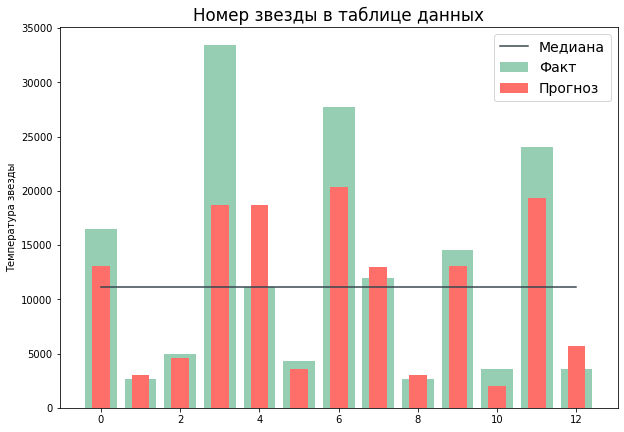

In [42]:
# построим диаграмму значений
fig, ax = plt.subplots(figsize=(10, 7))
plt.rc('font', size=14)

ax.bar(x, y_test[:13], color='#96ceb4', label='Факт')
ax.bar(x, baseline_pred[:13], width = .45, color='#ff6f69', label='Прогноз')
ax.plot(x, [y_test[:13].median() for i in range(13)], color='#36454f', label='Медиана')



ax.set_ylabel('Температура звезды')
ax.set_title('Номер звезды в таблице данных')
ax.legend()
plt.show()

На графике видно, что показания модели отличаются от правильных ответов. Сеть уловила колебания значений температуры звезды, но выдает более точные предсказания для звезд, температура которых ниже или близка к медианному значению.

## Улучшение нейронной сети

### Регуляризации

Для улучшения качества нейронной сети попробуем применить методы регуляризации BatchNorm и Dropout с различными значениями параметров.

Перепишем класс нашей сети так, чтобы появилась возможность их добавить. Остальное в архитектуре сети менять не будем. Параметры слоев будем использовать те, которые получили в результате поиска на предыдущем шаге и сохранили в переменной best_params.

In [43]:
class NetReg(nn.Module):
    def __init__(self, 
                 n_in_neurons, 
                 n_hidden_neurons_1, 
                 n_hidden_neurons_2, 
                 n_hidden_neurons_3,
                 n_hidden_neurons_4,
                 n_out_neurons,
                 acf1,
                 acf2,
                 acf3,
                 acf4,
                 acf5,
                 reg1,
                 reg2,
                 reg3,
                 reg4
                ):
        super(NetReg, self).__init__()

        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.reg1 = reg1
        self.act1 = acf1

        self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
        self.reg2 = reg2
        self.act2 = acf2
        
        self.fc3 = nn.Linear(n_hidden_neurons_2, n_hidden_neurons_3)
        self.reg3 = reg3
        self.act3 = acf3

        self.fc4 = nn.Linear(n_hidden_neurons_3, n_hidden_neurons_4)
        self.reg4 = reg4
        self.act4 = acf4
        
        self.fc5 = nn.Linear(n_hidden_neurons_4, n_out_neurons)
        self.act5 = acf5
        
        # Инициализация весов с использованием метода "Xavier/Glorot"
        nn.init.xavier_normal_(self.fc1.weight)
        nn.init.xavier_normal_(self.fc2.weight)
        nn.init.xavier_normal_(self.fc3.weight)
        nn.init.xavier_normal_(self.fc4.weight)

    def forward(self, x):
        x = self.fc1(x)
        x = self.reg1(x)
        x = self.act1(x)
        
        x = self.fc2(x)
        x = self.reg2(x)    
        x = self.act2(x)

        x = self.fc3(x)
        x = self.reg3(x)
        x = self.act3(x)
        
        x = self.fc4(x)
        x = self.reg4(x)
        x = self.act4(x)
        
        x = self.fc5(x)
        x = self.act5(x)
        return x

In [44]:
# пространство параметров для перебора 
params_for_reg = [
    [nn.Dropout(p=0.2),
    nn.Dropout(p=0.2),
    nn.Dropout(p=0.2),
    nn.Dropout(p=0.2)],
    [nn.Dropout(p=0.1),
    nn.Dropout(p=0.2),
    nn.Dropout(p=0.3),
    nn.Dropout(p=0.4)],
    [nn.Dropout(p=0.5),
    nn.Dropout(p=0.2),
    nn.Dropout(p=0.5),
    nn.Dropout(p=0.4)],
    [nn.Dropout(p=0.3),
    nn.Dropout(p=0.5),
    nn.Dropout(p=0.3),
    nn.Dropout(p=0.2)],
    [nn.BatchNorm1d(best_params[0]), 
     nn.BatchNorm1d(best_params[1]), 
     nn.BatchNorm1d(best_params[2]),
    nn.BatchNorm1d(best_params[3])]
]

In [45]:
# поиск лучшего набора параметров
reg_net = None
reg_rmse = 15_000

for params in params_for_reg:
    print('params:', params)
    
    model = NetReg(
        x_train_ohe_scaled.shape[1],
        *best_params, 
        *params
    )
    random.seed(baseline_seed)
    np.random.seed(baseline_seed)
    torch.manual_seed(baseline_seed)
    torch.use_deterministic_algorithms(True)
    loss = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-3)
    num_epochs = 2001
    print('epoch |', 'trainRMSE  |', 'testRMSE')
    print('-------------------------------')
    for epoch in range(num_epochs):

        optimizer.zero_grad()

        preds = model.forward(X_train).flatten()

        loss_value = loss(preds, Y_train)
        loss_value.backward()
        optimizer.step()

        if (epoch % 200 == 0) or (epoch == num_epochs) :
            model.eval()
            train_preds = model.forward(X_train).flatten()
            loss_value_train = torch.sqrt(loss(train_preds, Y_train))
            test_preds = model.forward(X_test).flatten()
            loss_value_test = torch.sqrt(loss(test_preds, Y_test))

            print(
                f'{epoch:5} | {loss_value_train.tolist():.4f} | {loss_value_test.tolist():.4f}'
            )
            model.train()
            if loss_value_test < reg_rmse:
                reg_net = model
                reg_rmse = loss_value_test
                best_reg_params = params
    print('****************')            
    print()
print('Best model:')
print('RMSE:', f'{reg_rmse.tolist():.4f}') 
print('best_reg_params:', best_reg_params)
print(reg_net)

params: [Dropout(p=0.2, inplace=False), Dropout(p=0.2, inplace=False), Dropout(p=0.2, inplace=False), Dropout(p=0.2, inplace=False)]
epoch | trainRMSE  | testRMSE
-------------------------------
    0 | 13952.4355 | 14695.4814
  200 | 13768.8926 | 14517.6826
  400 | 6896.4717 | 7523.5718
  600 | 5393.9517 | 5998.5615
  800 | 4918.4712 | 5567.8447
 1000 | 4753.7500 | 5472.9497
 1200 | 4603.6748 | 5360.4380
 1400 | 4476.2031 | 5279.9077
 1600 | 4480.1709 | 5371.2749
 1800 | 4435.2266 | 5401.4185
 2000 | 4288.0977 | 5309.6821
****************

params: [Dropout(p=0.1, inplace=False), Dropout(p=0.2, inplace=False), Dropout(p=0.3, inplace=False), Dropout(p=0.4, inplace=False)]
epoch | trainRMSE  | testRMSE
-------------------------------
    0 | 13952.5938 | 14695.6367
  200 | 13858.4307 | 14599.9697
  400 | 7043.2378 | 7565.6211
  600 | 5535.4873 | 6063.7354
  800 | 5135.7905 | 5740.3833
 1000 | 5076.6899 | 5746.3594
 1200 | 4957.7227 | 5680.3501
 1400 | 4775.1274 | 5539.5190
 1600 | 4860.7

Добавление Dropout и BatchNorm само по себе не привело к желаемому улучшению показателей работы сети.

Добавим пакетное обучение.

### Пакетное обучение

In [46]:
# попробуем разные размеры батчей
batch_sizes = [20, 50, 75, 100]

In [48]:
best_net_with_batches = None
best_rmse_with_batches = 15_000
for batch_size in batch_sizes:
    print('batch_size:', batch_size)
    
    new_net = Net(
                x_train_ohe_scaled.shape[1],
                *best_params
            )
    random.seed(baseline_seed)
    np.random.seed(baseline_seed)
    torch.manual_seed(baseline_seed)
    torch.use_deterministic_algorithms(True)

    optimizer = torch.optim.Adam(new_net.parameters(), lr=1e-3)

    loss = torch.nn.MSELoss()

    num_epochs = 1501

    num_batches = ceil(len(X_train)/batch_size)
    print('epoch |', 'trainRMSE  |', 'testRMSE')
    print('-------------------------------')
    for epoch in range(num_epochs):
        order = np.random.permutation(len(X_train)) # создайте случайную перестановку индексов объектов
        for batch_idx in range(num_batches):
            start_index = batch_idx * batch_size# посчитайте номер стартового объекта батча
            optimizer.zero_grad()

            batch_indexes = order[start_index:start_index+batch_size] # извлеките индексы объектов текущего обатча
            X_batch = X_train[batch_indexes]
            y_batch = Y_train[batch_indexes]

            preds = new_net.forward(X_batch).flatten()

            loss_value = loss(preds, y_batch)

            loss_value.backward()

            optimizer.step()

        if epoch % 100 == 0 or epoch == num_epochs - 1:
            new_net.eval()
            train_preds = new_net.forward(X_train).flatten()
            loss_value_train = torch.sqrt(loss(train_preds, Y_train))
            test_preds = new_net.forward(X_test).flatten()
            loss_value_test = torch.sqrt(loss(test_preds, Y_test))

            print(
                f'{epoch:5} | {loss_value_train.tolist():.4f} | {loss_value_test.tolist():.4f}'
            )
            new_net.train()
            if loss_value_test < best_rmse_with_batches:
                best_net_with_batches = new_net
                best_rmse_with_batches = loss_value_test
                best_batch_size = batch_size
                best_epoch = epoch
    print('****************')            
    print()
print('Best model:')
print('RMSE:', f'{best_rmse_with_batches.tolist():.4f}') 
print('best_batch_size:', best_batch_size)
print('best_epoch:', best_epoch)

print(best_net_with_batches)

batch_size: 20
epoch | trainRMSE  | testRMSE
-------------------------------
    0 | 13952.4004 | 14695.4453
  100 | 4840.7051 | 5367.9229
  200 | 4305.7676 | 5003.0464
  300 | 4090.0049 | 4951.9307
  400 | 3947.7332 | 5011.5674
  500 | 3859.0327 | 5121.1387
  600 | 3804.9697 | 5227.8979
  700 | 3771.9065 | 5273.0220
  800 | 3741.8701 | 5336.7275
  900 | 3715.3586 | 5353.4292
 1000 | 3691.4226 | 5365.7197
 1100 | 3662.5234 | 5384.8804
 1200 | 3633.9053 | 5370.3345
 1300 | 3602.1919 | 5359.5225
 1400 | 3564.2544 | 5366.1558
 1500 | 3520.9949 | 5348.1387
****************

batch_size: 50
epoch | trainRMSE  | testRMSE
-------------------------------
    0 | 13952.4209 | 14695.4668
  100 | 8029.5044 | 8772.9756
  200 | 4849.2026 | 5352.2534
  300 | 4453.5200 | 5059.0444
  400 | 4275.3232 | 4973.4941
  500 | 4146.1284 | 4952.4346
  600 | 4041.0544 | 4980.1548
  700 | 3963.8433 | 5007.9849
  800 | 3911.3152 | 5094.1387
  900 | 3864.2336 | 5125.8804
 1000 | 3833.8296 | 5178.5913
 1100 | 3808.1

По характеру записей о процессе обучения модели можно сделать вывод о наличии переобучения. До определенного времени показатель ошибки на тестовых данных уменьшается вместе с показателем для обучающей выборки. В какой-то момент показатель на тренировочной выборке улучшается, а на тестовой начинает падать. 

В коде сохраняется модель с наилучшими показателями. В дальнейшем будем использовать ее.


В результате экспериментов не удалось опустить метрику RMSE ниже 4900. Скорее всего это связано с тем, что для обучения у нас мало данных. Попробуем увеличить из с помощью аугментации.

### Аугментация данных

Попробуем добавить немного шума к данным (признак 'Абсолютная звёздная величина'), используя генератор нормального распределения из библиотеки NumPy. 

In [49]:
data = x_train_ohe
 
# добавление шума к числовым данным
noisy_data = data.copy()
noisy_data['absolute_magnitude_(mv)'] = noisy_data['absolute_magnitude_(mv)'] + np.random.normal(0, 1, len(noisy_data))


Сравним изначальные данные и зашумлённые.

In [50]:
# изначально
data.head()

,luminosity_(l/lo),radius_(r/ro),absolute_magnitude_(mv),ohe0,ohe1,ohe2,ohe3,ohe4,ohe5,ohe6,ohe7,ohe8,ohe9,ohe10,ohe11,ohe12,ohe13
0,0.00008,0.0130,14.08,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.00064,0.1090,17.12,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.00100,0.3500,11.76,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.00056,0.0095,13.78,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.00065,0.1100,16.98,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [51]:
# с шумом
noisy_data.head()

,luminosity_(l/lo),radius_(r/ro),absolute_magnitude_(mv),ohe0,ohe1,ohe2,ohe3,ohe4,ohe5,ohe6,ohe7,ohe8,ohe9,ohe10,ohe11,ohe12,ohe13
0,0.00008,0.0130,15.191184,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.00064,0.1090,16.511566,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.00100,0.3500,11.472394,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.00056,0.0095,15.060193,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.00065,0.1100,16.495014,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [52]:
# проверка размерности
noisy_data.shape, data.shape

((168, 17), (168, 17))

In [53]:
# масштабируем данные
noisy_data_scaled = pd.DataFrame(scaler.transform(noisy_data))

Добавим зашумленные данные к изначальной обучающей выборке. Тестовую выборку оставим без изменений.

In [54]:
# новый более крупный датасет
new_data = pd.concat([x_train_ohe_scaled, noisy_data_scaled], axis=0, ignore_index=True)

In [55]:
# проверка размерности
new_data.shape

(336, 17)

In [56]:
new_data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,-0.605495,-0.432609,0.921181,-0.540655,-0.456764,-0.077382,12.922848,-0.919866,-0.264695,-0.237915,-0.109764,-0.427900,-0.447214,2.144761,-0.466252,-0.456764,-0.418121
1,-0.605495,-0.432415,1.215105,-0.540655,-0.456764,-0.077382,-0.077382,1.087115,-0.264695,-0.237915,-0.109764,2.336993,-0.447214,-0.466252,-0.466252,-0.456764,-0.418121
2,-0.605495,-0.431926,0.696871,-0.540655,-0.456764,-0.077382,-0.077382,1.087115,-0.264695,-0.237915,-0.109764,-0.427900,2.236068,-0.466252,-0.466252,-0.456764,-0.418121
3,-0.605495,-0.432616,0.892176,-0.540655,-0.456764,-0.077382,-0.077382,-0.919866,3.777926,-0.237915,-0.109764,-0.427900,-0.447214,2.144761,-0.466252,-0.456764,-0.418121
4,-0.605495,-0.432413,1.201569,-0.540655,-0.456764,-0.077382,-0.077382,1.087115,-0.264695,-0.237915,-0.109764,2.336993,-0.447214,-0.466252,-0.466252,-0.456764,-0.418121


Добавим шум и к целевому признаку.

In [57]:
# повторяем предыдущие шаги для целевого признака
y_train_aug = y_train + np.random.normal(0, 1, len(noisy_data))
new_target = pd.concat([y_train, y_train_aug], axis=0, ignore_index=True)
new_target.shape

(336,)

In [58]:
new_target

0       7230.000000
1       3511.000000
2       3180.000000
3       8930.000000
4       2840.000000
           ...     
331    24630.124879
332     2650.971148
333     4077.847539
334    24488.541098
335    23000.990584
Name: temperature_(k), Length: 336, dtype: float64

Преобразуем новые данные в тензоры.

In [59]:
X_new_train = torch.FloatTensor(new_data.values)
Y_new_train = torch.FloatTensor(new_target.values)

Попробуем обучить на новых данных сеть с параметрами, полученными на прошлых шагах.

In [60]:
best_net_with_aug = None
best_rmse_with_aug = 15_000

aug_net = Net(
                x_train_ohe_scaled.shape[1],
                *best_params
            )

random.seed(baseline_seed)
np.random.seed(baseline_seed)
torch.manual_seed(baseline_seed)
torch.use_deterministic_algorithms(True)

optimizer = torch.optim.Adam(aug_net.parameters(), lr=1e-3)

loss = torch.nn.MSELoss()

batch_size = best_batch_size
num_epochs = 1501

num_batches = ceil(len(X_new_train)/batch_size)
print('epoch |', 'trainRMSE  |', 'testRMSE')
print('-------------------------------')
for epoch in range(num_epochs):
    order = np.random.permutation(len(X_new_train)) # создайте случайную перестановку индексов объектов
    for batch_idx in range(num_batches):
        start_index = batch_idx * batch_size# посчитайте номер стартового объекта батча
        optimizer.zero_grad()

        batch_indexes = order[start_index:start_index+batch_size] # извлеките индексы объектов текущего обатча
        X_batch = X_new_train[batch_indexes]
        y_batch = Y_new_train[batch_indexes]

        preds = aug_net.forward(X_batch).flatten()

        loss_value = loss(preds, y_batch)

        loss_value.backward()

        optimizer.step()

    if epoch % 100 == 0 or epoch == num_epochs - 1:
        aug_net.eval()
        train_preds = aug_net.forward(X_new_train).flatten()
        loss_value_train = torch.sqrt(loss(train_preds, Y_new_train))
        test_preds = aug_net.forward(X_test).flatten()
        loss_value_test = torch.sqrt(loss(test_preds, Y_test))

        print(
            f'{epoch:5} | {loss_value_train.tolist():.4f} | {loss_value_test.tolist():.4f}'
        )
        aug_net.train()
        if loss_value_test < best_rmse_with_aug:
                best_net_with_aug = aug_net
                best_rmse_with_aug = loss_value_test
                best_epoch_aug = epoch
print('****************')            
print()
print('Best model:')
print('RMSE:', f'{best_rmse_with_aug.tolist():.4f}') 
print('best_epoch:', best_epoch_aug)

print(best_net_with_aug)

epoch | trainRMSE  | testRMSE
-------------------------------
    0 | 13952.4639 | 14695.4668
  100 | 7767.5811 | 8479.8477
  200 | 4799.3364 | 5294.6802
  300 | 4394.8301 | 5029.2607
  400 | 4206.1709 | 4976.4941
  500 | 4067.2522 | 4974.4072
  600 | 3959.9109 | 5036.1050
  700 | 3886.1721 | 5111.3828
  800 | 3837.3706 | 5178.8511
  900 | 3801.5784 | 5251.0542
 1000 | 3775.0493 | 5292.2046
 1100 | 3750.2053 | 5325.5020
 1200 | 3728.8809 | 5350.0171
 1300 | 3710.3987 | 5374.5410
 1400 | 3690.0178 | 5411.9600
 1500 | 3673.0789 | 5434.7554
****************

Best model:
RMSE: 4974.4072
best_epoch: 500
Net(
  (fc1): Linear(in_features=17, out_features=20, bias=True)
  (act1): ReLU()
  (fc2): Linear(in_features=20, out_features=15, bias=True)
  (act2): ReLU()
  (fc3): Linear(in_features=15, out_features=10, bias=True)
  (act3): ReLU()
  (fc4): Linear(in_features=10, out_features=5, bias=True)
  (act4): ReLU()
  (fc5): Linear(in_features=5, out_features=1, bias=True)
  (act5): ReLU()
)


Видим, что аугментация не дала значительного улучшения результата. Скорее всего дело в том, что, используя генератор случайных чисел мы сделали главную закономерность между характеристиками и целевым признаком более размытой и это помешало сети правильно настроить свои внутренние параметры. 

В дальнейшем можно попробовать настроить уже имеющиеся библиотеки для аугментации табличных данных, такие как tabular_augmentation или DeltaPy⁠⁠. 

Можно попробовать написать свой класс генерации данных, куда заложить уже известные астрономам формулы, связывающие имеющиеся характеристики и целевой признак. 

Можно создать генеративную модель для этих же целей.  Думаю, что лучше всего обучать такую модель на звездах, температура которых больше 5000 К, потому что разработанные выше сети ошибаются сильнее всего именно на таких звездах, и причина в недостаточном количестве образцов.


## Анализ предсказаний нейронной сети после улучшения

Получим предсказания самой сильной нейронной сети после применения различных техник улучшения качества на тестовой выборке и построим такую же диаграмму, какую строили для бейзлайна.

Лучшая модель получилась после добавления пактного обучения. Состояние модели, при котором RMSE минимальна, мы сохранили в переменной best_net_with_batches во время подборки лучшего размера батча.

In [69]:
# параметры нейронной сети
best_net_with_batches

Net(
  (fc1): Linear(in_features=17, out_features=20, bias=True)
  (act1): ReLU()
  (fc2): Linear(in_features=20, out_features=15, bias=True)
  (act2): ReLU()
  (fc3): Linear(in_features=15, out_features=10, bias=True)
  (act3): ReLU()
  (fc4): Linear(in_features=10, out_features=5, bias=True)
  (act4): ReLU()
  (fc5): Linear(in_features=5, out_features=1, bias=True)
  (act5): ReLU()
)

In [70]:
# отберем предсказания для первых 13-ти наблюдений
best_net_pred = best_net_with_batches.forward(X_test).detach().numpy().reshape([-1])
x = [i for i in range(13)]

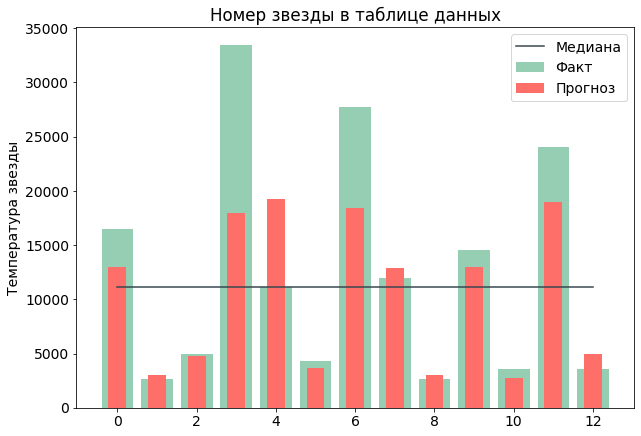

In [71]:
# построим диаграмму значений
fig, ax = plt.subplots(figsize=(10, 7))
plt.rc('font', size=14)

ax.bar(x, y_test[:13], color='#96ceb4', label='Факт')
ax.bar(x, best_net_pred[:13], width = .45, color='#ff6f69', label='Прогноз')
ax.plot(x, [y_test[:13].median() for i in range(13)], color='#36454f', label='Медиана')



ax.set_ylabel('Температура звезды')
ax.set_title('Номер звезды в таблице данных')
ax.legend()
plt.show()

На графике видно, что характер предсказаний сети значительно не изменился. 

## Сравнения всех полученных нейронных сетей

**Сравним RMSE нейронных сетей** на разных этапах разработки и сделаем вывод об эффективности различных методик повышения качества прогнозов.

In [72]:
rmse_list = [baseline_rmse.item(), reg_rmse.item(), best_rmse_with_batches.item(), best_rmse_with_aug.item()]
model_types = ['базовая', 'сеть с регуляризацией', 'базовая с пакетным обучением', 'базовая с аугментацией']

In [73]:
pd.DataFrame({'model' : model_types, 'rmse': rmse_list})

,model,rmse
0,базовая,4911.133789
1,сеть с регуляризацией,5279.907715
2,базовая с пакетным обучением,4939.277344
3,базовая с аугментацией,4974.407227


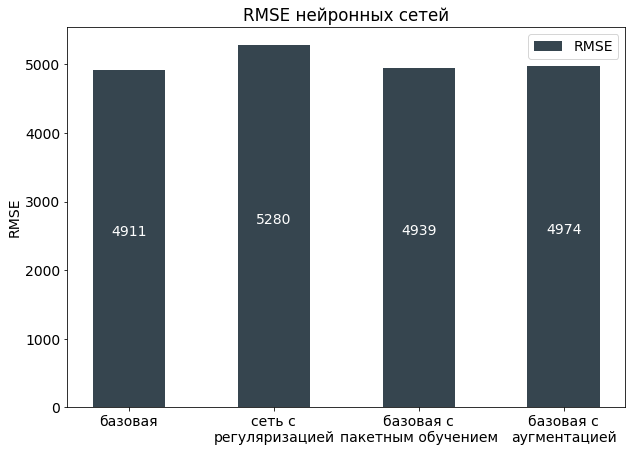

In [74]:
fig, ax = plt.subplots(figsize=(10, 7))
plt.rc('font', size=14)

ax.bar(
    ['базовая', 'сеть с\nрегуляризацией', 'базовая с\nпакетным обучением', 'базовая с\nаугментацией'], 
    rmse_list,
    color='#36454f', 
    label='RMSE', 
    width = 0.5
)
labels =[round(i) for i in rmse_list]

rects = ax.patches

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(
        rect.get_x() + rect.get_width() / 2, height / 2, label, ha="center", va="bottom", color='white'
    )


ax.set_ylabel('RMSE')
ax.set_title('RMSE нейронных сетей')
ax.legend()
plt.show()

Точнее всех оказалась базовая модель. Применение дополнительных техник не привело к значительному улучшению качества модели.

### Вывод по результатам построения нейронной сети

На преобразованных данных была построена **нейронная сеть с четырьмя промежуточными слоями**.

Первоначальная модель давала предсказания, близкие к медианному значению.

**Для улучшения качества** предсказаний модели **опробованы**:
- перебор нескольких вариантов количества нейронов в скрытых слоях
- перебор нескольких вариантов функций активации
- применение Dropout и BatchNormalization
- пакетное обучение
- аугментация данных

Эксперименты показали, что **точнее всех оказалась базовая модель**. Применение дополнительных техник не привело к значительному улучшению качества модели.


## Выводы

В данном проекте решена **задача** от обсерватории «Небо на ладони»: придумать, как **с помощью нейросети определять температуру на поверхности обнаруженных звёзд**.

**Описание данных**

В доступном наборе данных содержатся результаты измерений шести параметров 240 звезд. Три признака количественные, два – категориальные.

Большинство звезд имеют температуру ниже 5000 К, относительный радиус и относительную светимость, близкие к показателям Солнца. Всего в наборе есть данные о 6 типах звезд, по 40 примеров каждого типа. Из девяти цветов чаще всего в наборе данных встречается красный, на втором месте по популярности голубой и бело-голубой.

**Преобразование данных**

Данные были разбиты на тренировочную и тестовую выборки в соотношении 70 : 30. Для преобразования категориальных значений применена техника One-Hot кодирования. Признаки масштабированы так, чтобы их значения находились в диапазоне от 0 до 1. Прошедшие преобразования данные представлены в виде тензоров для передачи их нейронной сети.

**Построение нейронной сети**

На преобразованных данных была построена **нейронная сеть с четырьмя промежуточными слоями**. Первоначальная модель давала предсказания, близкие к медианному значению.

**Для улучшения качества предсказаний** модели опробованы:
- перебор нескольких вариантов количества нейронов в скрытых слоях
- перебор нескольких вариантов функций активации
- применение Dropout и BatchNormalization
- пакетное обучение
- аугментация данных

Эксперименты показали, что **точнее всех оказалась базовая модель**. Применение дополнительных техник не привело к значительному улучшению качества модели.

В результате **лучшей оказалась нейронная сеть со следующими параметрами**:


In [75]:
baseline

Net(
  (fc1): Linear(in_features=17, out_features=20, bias=True)
  (act1): ReLU()
  (fc2): Linear(in_features=20, out_features=15, bias=True)
  (act2): ReLU()
  (fc3): Linear(in_features=15, out_features=10, bias=True)
  (act3): ReLU()
  (fc4): Linear(in_features=10, out_features=5, bias=True)
  (act4): ReLU()
  (fc5): Linear(in_features=5, out_features=1, bias=True)
  (act5): ReLU()
)

**RMSE предсказаний нейронной сети**

In [76]:
baseline_rmse.item()

4911.1337890625